In [1]:
import tensorflow as tf
import os
import numpy as np
import glob
import random
import cv2
from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, BatchNormalization,Conv2DTranspose, concatenate,Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
from keras import backend as K


In [2]:
data_folder = r"C:\Users\Desktop\data"

In [3]:
train_folder = os.path.join(data_folder, "train")
test_folder = os.path.join(data_folder, "test")
validation_folder = os.path.join(data_folder, "validation")

In [4]:
img_width = 128
img_height = 128
img_channels = 3
num_filters = 4

In [5]:
#####Train
train_data = []
train_mask = []

for patient_folder in glob.glob(os.path.join(train_folder, "patient")):
    image_folder = os.path.join(patient_folder, "image")
    mask_folder = os.path.join(patient_folder, "mask")

    # image ve mask dosyalarını sırayla eşleştir
    for image_path, mask_path in zip(glob.glob(os.path.join(image_folder, "*.png")),
                                     glob.glob(os.path.join(mask_folder, "*.png"))):
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        train_data.append(image)
        train_mask.append(mask)

# Veri --> numpy
train_data = np.array(train_data, dtype=object)
train_mask = np.array(train_mask, dtype=object)

#####Test
test_data = []
test_mask = []

for patient_folder in glob.glob(os.path.join(test_folder, "patient")):
    image_folder = os.path.join(patient_folder, "image")
    mask_folder = os.path.join(patient_folder, "mask")

    # image ve mask dosyalarını sırayla eşleştir
    for image_path, mask_path in zip(glob.glob(os.path.join(image_folder, "*.png")),
                                     glob.glob(os.path.join(mask_folder, "*.png"))):
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        test_data.append(image)
        test_mask.append(mask)

# Veri --> numpy
test_data = np.array(test_data, dtype=object)
test_mask = np.array(test_mask, dtype=object)

#####Validation
validation_data = []
validation_mask = []

for patient_folder in glob.glob(os.path.join(validation_folder, "patient")):
    image_folder = os.path.join(patient_folder, "image")
    mask_folder = os.path.join(patient_folder, "mask")

    for image_path in glob.glob(os.path.join(image_folder, "*.png")):
        image = cv2.imread(image_path)
        validation_data.append(image)

    for mask_path in glob.glob(os.path.join(mask_folder, "*.png")):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        validation_mask.append(mask)

# Veri --> numpy
validation_data = np.array(validation_data, dtype=object)
validation_mask = np.array(validation_mask, dtype=object)


print("Eğitim verilerinin boyutu:", train_data.shape)
print("Eğitim maskelerinin boyutu:", train_mask.shape)
print("Test verilerinin boyutu:", test_data.shape)
print("Test maskelerinin boyutu:", test_data.shape)
print("validation verilerinin boyutu:", validation_data.shape)
print("validation maskelerinin boyutu:", validation_mask.shape)

Eğitim verilerinin boyutu: (1944,)
Eğitim maskelerinin boyutu: (1944,)
Test verilerinin boyutu: (282,)
Test maskelerinin boyutu: (282,)
validation verilerinin boyutu: (283,)
validation maskelerinin boyutu: (283,)


In [6]:
#Train
img_width = 128
img_height = 128

resized_train_data = []
for image in train_data:
    resized_image = cv2.resize(image, (img_width, img_height))
    normalized_image = resized_image / 255.0  # 0-255 arası piksel değerlerini 0-1 arasına dönüştür
    resized_train_data.append(normalized_image)

resized_train_data = np.array(resized_train_data)

resized_train_mask = []
for mask in train_mask:
    resized_mask = cv2.resize(mask, (img_width, img_height))
    resized_mask = resized_mask/255.0
    resized_train_mask.append(resized_mask)
resized_train_mask = np.array(resized_train_mask)

resized_train_mask = resized_train_mask.reshape(-1, 128, 128, 1)
print("Yeniden boyutlandırılmış ve normalleştirilmiş eğitim verilerinin boyutu:", resized_train_data.shape)
print("Yeniden boyutlandırılmış ve normalleştirilmiş eğitim maske verilerinin boyutu:", resized_train_mask.shape)

#Test

resized_test_data = []

for image in test_data:
    resized_image = cv2.resize(image, (img_width, img_height))
    normalized_image = resized_image / 255.0  # 0-255 arası piksel değerlerini 0-1 arasına dönüştür
    resized_test_data.append(normalized_image)

resized_test_data = np.array(resized_test_data)

resized_test_mask = []

for mask in test_mask:
    resized_mask = cv2.resize(mask, (img_width, img_height))
    resized_mask = resized_mask / 255.0
    resized_test_mask.append(resized_mask)

resized_test_mask = np.array(resized_test_mask)
resized_test_mask = resized_test_mask.reshape(-1, img_width, img_height, 1)
print("Yeniden boyutlandırılmış ve normalleştirilmiş test verilerinin boyutu:", resized_test_data.shape)
print("Yeniden boyutlandırılmış ve normalleştirilmiş test maske verilerinin boyutu:", resized_test_mask.shape)

#Validation

resized_validation_data = []
for image in validation_data:
    resized_image = cv2.resize(image, (img_width, img_height))
    normalized_image = resized_image / 255.0  # 0-255 arası piksel değerlerini 0-1 arasına dönüştür
    resized_validation_data.append(normalized_image)

resized_validation_data = np.array(resized_validation_data)

resized_validation_mask = []
for mask in validation_mask:
    resized_mask = cv2.resize(mask, (img_width, img_height))
    normalized_mask = resized_mask / 255.0
    resized_validation_mask.append(normalized_mask)
resized_validation_mask = np.array(resized_validation_mask)
resized_validation_mask = resized_validation_mask.reshape(-1, img_width, img_height, 1)

print("Yeniden boyutlandırılmış ve normalleştirilmiş validation  verilerinin boyutu:", resized_validation_data.shape)
print("Yeniden boyutlandırılmış ve normalleştirilmiş validation  maske verilerinin boyutu:", resized_validation_mask.shape)


Yeniden boyutlandırılmış ve normalleştirilmiş eğitim verilerinin boyutu: (1944, 128, 128, 3)
Yeniden boyutlandırılmış ve normalleştirilmiş eğitim maske verilerinin boyutu: (1944, 128, 128, 1)
Yeniden boyutlandırılmış ve normalleştirilmiş test verilerinin boyutu: (282, 128, 128, 3)
Yeniden boyutlandırılmış ve normalleştirilmiş test maske verilerinin boyutu: (282, 128, 128, 1)
Yeniden boyutlandırılmış ve normalleştirilmiş validation  verilerinin boyutu: (283, 128, 128, 3)
Yeniden boyutlandırılmış ve normalleştirilmiş validation  maske verilerinin boyutu: (283, 128, 128, 1)


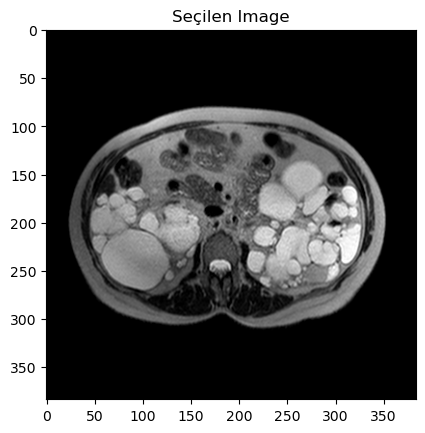

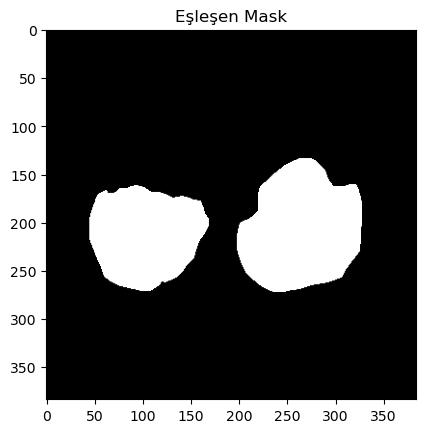

In [7]:
# Rastgele bir hastayı ve image/mask çiftini seçme
random_patient_folder = random.choice(glob.glob(os.path.join(train_folder, "patient")))
image_folder = os.path.join(random_patient_folder, "image")
mask_folder = os.path.join(random_patient_folder, "mask")

# image ve mask dosyalarını listeleme
image_files = glob.glob(os.path.join(image_folder, "*.png"))
mask_files = glob.glob(os.path.join(mask_folder, "*.png"))

# Rastgele bir image seçme
random_image_path = random.choice(image_files)
random_image = cv2.imread(random_image_path)

# Seçilen image ile hangi mask dosyasının eşleştiğini bulma
image_name = os.path.basename(random_image_path)
image_id = os.path.splitext(image_name)[0]
matching_mask_path = os.path.join(mask_folder, f"{image_id}.png")

# Eşleşen mask dosyasını yükleme
matching_mask = cv2.imread(matching_mask_path, cv2.IMREAD_GRAYSCALE)

# Seçilen Image'i görüntüleme
plt.imshow(random_image)
plt.title("Seçilen Image")
plt.show()

# Eşleşen mask'ı uygun bir NumPy dizisine dönüştürme
matching_mask = np.array(matching_mask, dtype=np.uint8)

plt.imshow(matching_mask, cmap='gray')
plt.title("Eşleşen Mask")
plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artırma parametrelerini belirle
datagen = ImageDataGenerator(
    rotation_range=20,      # Rastgele döndürme (0 ile belirtilen derece arasında)
    width_shift_range=0.2,  # Genişlik yönlü kayma
    height_shift_range=0.2, # Yükseklik yönlü kayma
    shear_range=0.2,        # Kesme etkisi
    zoom_range=0.2,         # Rastgele yakınlaştırma
    horizontal_flip=True,   # Yatay çevirme
    vertical_flip=True,     # Dikey çevirme
    fill_mode='nearest',     # Eksik pikselleri doldurma yöntemi  
)

# Eğitim verisi ve maskeleri için veri artırma uygula
augmented_train_data = []
augmented_train_mask = []

for i in range(len(resized_train_data)):
    img = resized_train_data[i]
    mask = resized_train_mask[i]

    img = img.reshape((1,) + img.shape)  # Veri artırma işlemi genellikle batch olarak yapılır
    mask = mask.reshape((1,) + mask.shape)

    seed = np.random.randint(1, 1000)
    img_gen = datagen.flow(img, batch_size=1, seed=seed)
    mask_gen = datagen.flow(mask, batch_size=1, seed=seed)

    augmented_train_data.append(img_gen[0][0])
    augmented_train_mask.append(mask_gen[0][0])

augmented_train_data = np.array(augmented_train_data)
augmented_train_mask = np.array(augmented_train_mask)

# Veri artırma sonrası boyutları kontrol et
print("Veri artırma sonrası eğitim verilerinin boyutu:", augmented_train_data.shape)
print("Veri artırma sonrası eğitim maskelerinin boyutu:", augmented_train_mask.shape)


Veri artırma sonrası eğitim verilerinin boyutu: (1944, 128, 128, 3)
Veri artırma sonrası eğitim maskelerinin boyutu: (1944, 128, 128, 1)


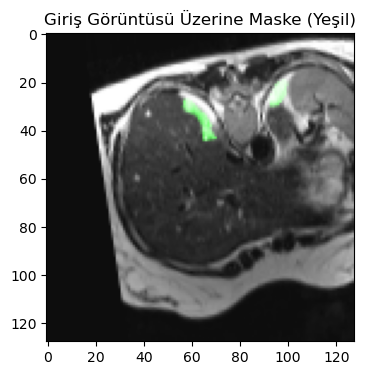

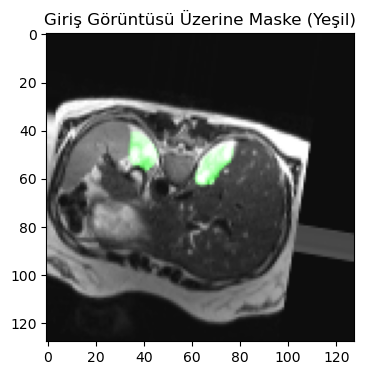

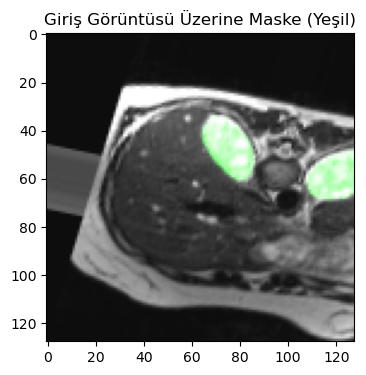

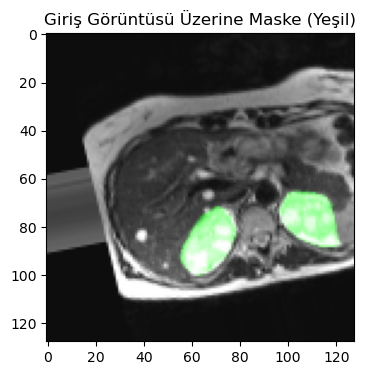

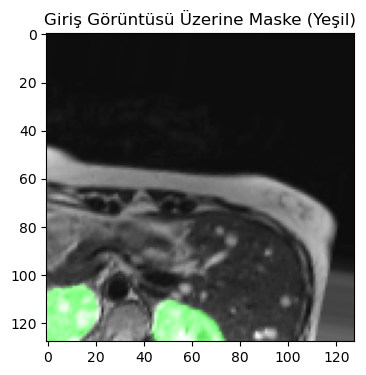

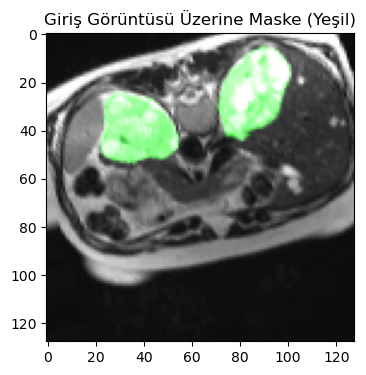

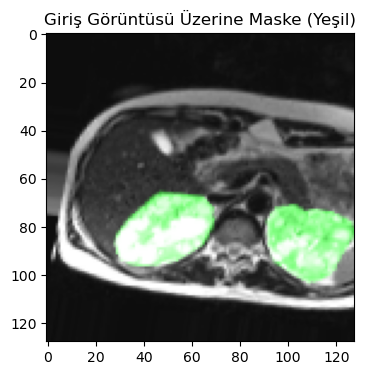

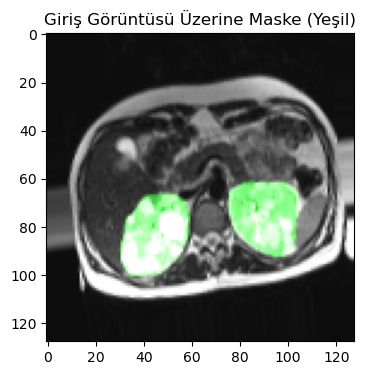

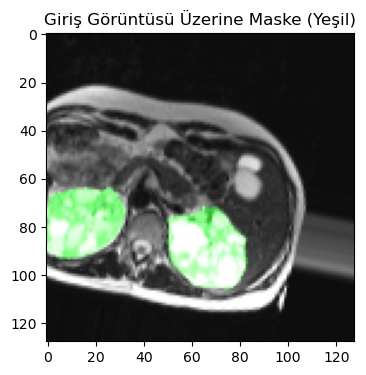

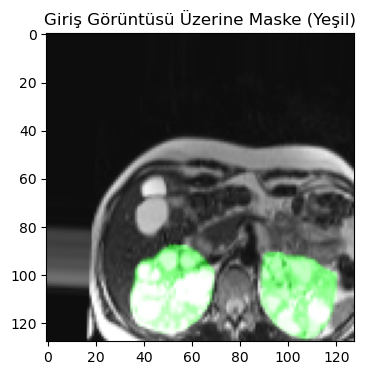

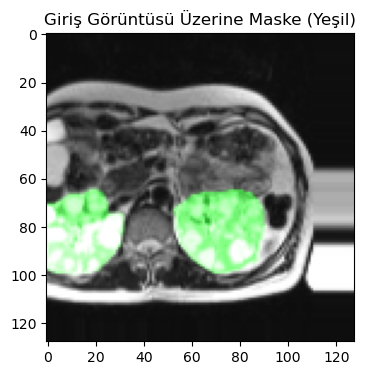

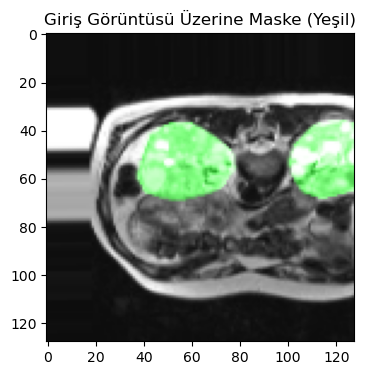

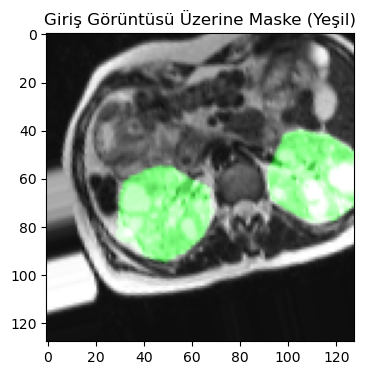

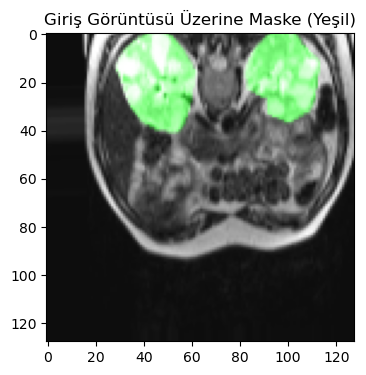

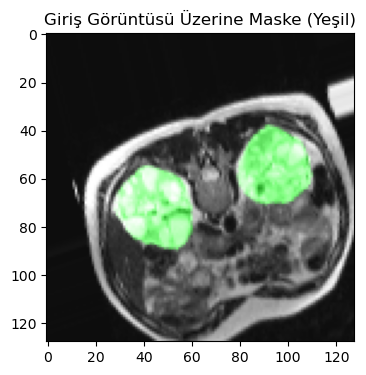

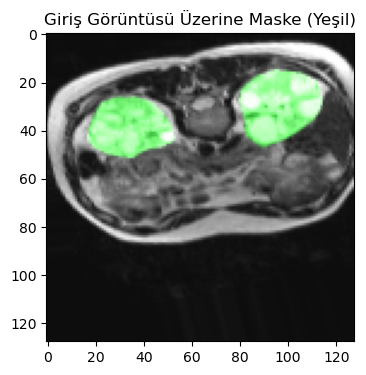

In [9]:
# İlk 16 artırılmış görüntü ve maskeleri alın
sample_images = augmented_train_data[:16]
sample_masks = augmented_train_mask[:16]

# Her bir örneği görselleştirme
for i in range(16):
    input_image = (sample_images[i] * 255).astype(np.uint8)  # Giriş görüntüsünü 0-255 aralığına geri getir
    real_mask = (sample_masks[i] * 255).astype(np.uint8).reshape(img_height, img_height)

    # Renkli maskeyi oluştur
    colored_mask = cv2.cvtColor(real_mask, cv2.COLOR_GRAY2RGB)
    colored_mask[:,:,0] = 0  # Mavi kanalı sıfır yap
    colored_mask[:,:,2] = 0  # Kırmızı kanalı sıfır yap

    # Giriş görüntüsü ve üstüne maskenin eklenmesi
    overlay = cv2.addWeighted(input_image, 1, colored_mask, 0.5, 0)

    # Görselleştirme
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 1, 1)
    plt.imshow(overlay)
    plt.title('Giriş Görüntüsü Üzerine Maske (Yeşil)')

    plt.show()


In [8]:
# Orijinal ve artırılmış verileri birleştirme
combined_train_data = np.concatenate((resized_train_data, augmented_train_data), axis=0)
combined_train_mask = np.concatenate((resized_train_mask, augmented_train_mask), axis=0)

# Veri birleştirme sonrası boyutları kontrol et
print("Birleştirilmiş eğitim verilerinin boyutu:", combined_train_data.shape)
print("Birleştirilmiş eğitim maskelerinin boyutu:", combined_train_mask.shape)

Birleştirilmiş eğitim verilerinin boyutu: (3888, 128, 128, 3)
Birleştirilmiş eğitim maskelerinin boyutu: (3888, 128, 128, 1)


In [9]:
input_shape = (img_height, img_width, img_channels)  # Bu örnekte img_width=128, img_height=128, img_channels=3 olarak tanımlanmıştır

def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)

    return x
   
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPool2D((2,2))(x)
    return x, p

def decoder_block(inputs, skip, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(inputs)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64) # 500 x 500
    s2, p2 = encoder_block(p1, 128) # 250 x 250
    s3, p3 = encoder_block(p2, 256) # 125 x 125
    s4, p4 = encoder_block(p3, 512) # 62 x 62

    # Bridge
    b1 = conv_block(p4, 1024) # 31 x 31

    # Decoder
    d1 = decoder_block(b1, s4, 512) # 31 x 31
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs, name="UNET")
    return model

In [10]:
# UNET modeli
u_net_model = build_unet(input_shape)  # input_shape'i belirlediğiniz şekilde tanımladığınızı varsayalım

# Model özeti
u_net_model.summary()


Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

 batch_normalization_9 (BatchNo  (None, 8, 8, 1024)  4096        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_9 (LeakyReLU)      (None, 8, 8, 1024)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 16, 16, 512)  2097664    ['leaky_re_lu_9[0][0]']          
 ose)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 16, 16, 1024  0           ['conv2d_transpose[0][0]',       
                                )                                 'leaky_re_lu_7[0][0]']          
          

 batch_normalization_17 (BatchN  (None, 128, 128, 64  256        ['conv2d_17[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 leaky_re_lu_17 (LeakyReLU)     (None, 128, 128, 64  0           ['batch_normalization_17[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 128, 128, 1)  65          ['leaky_re_lu_17[0][0]']         
                                                                                                  
Total params: 31,055,297
Trainable params: 31,043,521
Non-trainable params: 11,776
__________________________________________________________________________________________________


In [8]:
#custom loss and metrics functions
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=(1, 2))  # 128x128 piksel boyutunda toplama yap
    union = K.sum(y_true, axis=(1, 2)) + K.sum(y_pred, axis=(1, 2)) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def F1(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=(1, 2))  # 128x128 piksel boyutunda toplama yap
    precision = (intersection + smooth) / (K.sum(y_pred, axis=(1, 2)) + smooth)
    recall = (intersection + smooth) / (K.sum(y_true, axis=(1, 2)) + smooth)
    f1 = 2 * (precision * recall) / (precision + recall)
    return K.mean(f1)

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def dice_coef(y_true, y_pred, smooth = 0.00001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


# Grid Search

In [11]:
#pip install scikeras

In [12]:
from sklearn.model_selection import ParameterGrid, KFold

In [13]:
# Define the hyperparameters grid
param_grid = {
    'learning_rate': [1e-3, 5e-3, 1e-4],
    'batch_size': [32, 64],
    'epochs': [20, 40, 80]
}
# Convert the grid to a list of dictionaries
param_combinations = list(ParameterGrid(param_grid))


In [14]:
# Function to build and compile the U-Net model with given hyperparameters
def build_compile_unet(input_shape, num_filters, dropout_rate, learning_rate):
    model = build_unet(input_shape)
    model.compile(optimizer=Adam(learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', F1, recall, precision, dice_coef, iou])
    return model


In [15]:
best_model = None
best_dice_coefficient = 0
input_shape = (img_height, img_width, img_channel)

In [ ]:
for params in param_combinations:
    print(f"\nTraining with hyperparameters: {params}")

    # Build and compile model
    model = build_compile_unet(input_shape, params['learning_rate'])

    # Train the model
    history = model.fit(
        resized_train_data,
        resized_train_mask,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        validation_data=(resized_validation_data, resized_validation_mask),
        verbose=2
    )
    
    # Evaluate the model on validation data
    eval_metrics = model.evaluate(resized_validation_data, resized_validation_mask, verbose=0)

    # Assuming 'dice_coef' is the metric at index 5
    dice_coefficient = eval_metrics[5]
    print(f"Validation dice coefficient: {dice_coefficient}")

    if dice_coefficient > best_dice_coefficient:
        best_dice_coefficient = dice_coefficient
        best_model = model

print("\nBest Hyperparameters:")

In [ ]:
# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_indices, val_indices) in enumerate(kf.split(resized_train_data, resized_train_mask)):
    print(f"\n----- Fold {fold + 1} -----\n")

    train_data_fold, train_mask_fold = resized_train_data[train_indices], resized_train_mask[train_indices]
    val_data_fold, val_mask_fold = resized_train_data[val_indices], resized_train_mask[val_indices]

    for params in param_combinations:
        print(f"\nTraining with hyperparameters: {params}")

        # Build and compile the model
        model = build_compile_unet(input_shape, params['num_filters'], params['dropout_rate'], params['learning_rate'])

        # Train the model
        history = model.fit(
            train_data_fold,
            train_mask_fold,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            validation_data=(val_data_fold, val_mask_fold),
            verbose=2
        )

        # Evaluate the model on the validation set using dice_coef metric
        eval_metrics = model.evaluate(val_data_fold, val_mask_fold, verbose=0)

        # Extract the dice_coef value from the evaluation metrics
        dice_coefficient = eval_metrics[5]  # Assuming dice_coef is the 6th metric in your metrics list
        print(f"Validation Dice Coefficient: {dice_coefficient}")

        # Check if this model has the best validation Dice coefficient
        if dice_coefficient > best_dice_coefficient:
            best_dice_coefficient = dice_coefficient
            best_model = model



# Print the best hyperparameters
print("\nBest Hyperparameters:")
print(best_model.get_config())


----- Fold 1 -----


Training with hyperparameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'num_filters': 16}
Epoch 1/20
86/86 - 695s - loss: 0.1733 - accuracy: 0.9546 - F1: 0.3501 - recall: 0.6735 - precision: 0.7329 - dice_coef: 0.3912 - iou: 0.2310 - val_loss: 9.9715 - val_accuracy: 0.6499 - val_F1: 0.0965 - val_recall: 0.3079 - val_precision: 0.0510 - val_dice_coef: 0.0995 - val_iou: 0.0524 - 695s/epoch - 8s/step
Epoch 2/20
86/86 - 697s - loss: 0.0609 - accuracy: 0.9817 - F1: 0.5719 - recall: 0.8182 - precision: 0.8461 - dice_coef: 0.6428 - iou: 0.4257 - val_loss: 0.2152 - val_accuracy: 0.9327 - val_F1: 0.3056 - val_recall: 0.5793 - val_precision: 0.4225 - val_dice_coef: 0.3364 - val_iou: 0.1964 - 697s/epoch - 8s/step
Epoch 3/20
86/86 - 691s - loss: 0.0476 - accuracy: 0.9826 - F1: 0.6401 - recall: 0.8359 - precision: 0.8482 - dice_coef: 0.7131 - iou: 0.4983 - val_loss: 0.2691 - val_accuracy: 0.9163 - val_F1: 0.4207 - val_recall: 0.9737 - val_

Epoch 7/20
86/86 - 692s - loss: 0.0256 - accuracy: 0.9886 - F1: 0.7784 - recall: 0.8934 - precision: 0.9017 - dice_coef: 0.8433 - iou: 0.6641 - val_loss: 0.0390 - val_accuracy: 0.9832 - val_F1: 0.6801 - val_recall: 0.7441 - val_precision: 0.9468 - val_dice_coef: 0.7796 - val_iou: 0.5565 - 692s/epoch - 8s/step
Epoch 8/20
86/86 - 693s - loss: 0.0220 - accuracy: 0.9898 - F1: 0.8067 - recall: 0.9076 - precision: 0.9123 - dice_coef: 0.8653 - iou: 0.6992 - val_loss: 0.0324 - val_accuracy: 0.9864 - val_F1: 0.7875 - val_recall: 0.8338 - val_precision: 0.9223 - val_dice_coef: 0.8437 - val_iou: 0.6761 - 693s/epoch - 8s/step
Epoch 9/20
86/86 - 697s - loss: 0.0219 - accuracy: 0.9898 - F1: 0.8101 - recall: 0.9075 - precision: 0.9126 - dice_coef: 0.8673 - iou: 0.7040 - val_loss: 0.0252 - val_accuracy: 0.9887 - val_F1: 0.8146 - val_recall: 0.9115 - val_precision: 0.8923 - val_dice_coef: 0.8690 - val_iou: 0.7122 - 697s/epoch - 8s/step
Epoch 10/20
86/86 - 692s - loss: 0.0205 - accuracy: 0.9903 - F1: 0.

Epoch 13/20
86/86 - 688s - loss: 0.0161 - accuracy: 0.9919 - F1: 0.8595 - recall: 0.9295 - precision: 0.9314 - dice_coef: 0.9025 - iou: 0.7697 - val_loss: 0.0205 - val_accuracy: 0.9901 - val_F1: 0.8483 - val_recall: 0.9430 - val_precision: 0.8925 - val_dice_coef: 0.8941 - val_iou: 0.7570 - 688s/epoch - 8s/step
Epoch 14/20
86/86 - 689s - loss: 0.0158 - accuracy: 0.9920 - F1: 0.8638 - recall: 0.9296 - precision: 0.9336 - dice_coef: 0.9046 - iou: 0.7753 - val_loss: 0.0205 - val_accuracy: 0.9903 - val_F1: 0.8356 - val_recall: 0.9150 - val_precision: 0.9186 - val_dice_coef: 0.8907 - val_iou: 0.7419 - 689s/epoch - 8s/step
Epoch 15/20
86/86 - 692s - loss: 0.0144 - accuracy: 0.9926 - F1: 0.8748 - recall: 0.9366 - precision: 0.9374 - dice_coef: 0.9126 - iou: 0.7911 - val_loss: 0.0183 - val_accuracy: 0.9912 - val_F1: 0.8629 - val_recall: 0.9394 - val_precision: 0.9123 - val_dice_coef: 0.9042 - val_iou: 0.7769 - 692s/epoch - 8s/step
Epoch 16/20
86/86 - 690s - loss: 0.0152 - accuracy: 0.9922 - F1:

Epoch 19/20
86/86 - 690s - loss: 0.0128 - accuracy: 0.9934 - F1: 0.8875 - recall: 0.9447 - precision: 0.9456 - dice_coef: 0.9213 - iou: 0.8093 - val_loss: 0.0184 - val_accuracy: 0.9916 - val_F1: 0.8511 - val_recall: 0.9011 - val_precision: 0.9580 - val_dice_coef: 0.9071 - val_iou: 0.7667 - 690s/epoch - 8s/step
Epoch 20/20
86/86 - 691s - loss: 0.0113 - accuracy: 0.9940 - F1: 0.9010 - recall: 0.9488 - precision: 0.9522 - dice_coef: 0.9300 - iou: 0.8288 - val_loss: 0.0158 - val_accuracy: 0.9923 - val_F1: 0.8829 - val_recall: 0.9367 - val_precision: 0.9368 - val_dice_coef: 0.9178 - val_iou: 0.8037 - 691s/epoch - 8s/step
Validation Dice Coefficient: 0.9194111227989197

Training with hyperparameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.0005, 'num_filters': 32}
Epoch 1/20
86/86 - 693s - loss: 0.2377 - accuracy: 0.9385 - F1: 0.3063 - recall: 0.7213 - precision: 0.7505 - dice_coef: 0.3380 - iou: 0.1940 - val_loss: 69.5990 - val_accuracy: 0.0934 - val_F1: 0.1

Epoch 5/20
86/86 - 689s - loss: 0.0390 - accuracy: 0.9880 - F1: 0.6786 - recall: 0.8921 - precision: 0.8927 - dice_coef: 0.7505 - iou: 0.5401 - val_loss: 0.0593 - val_accuracy: 0.9798 - val_F1: 0.5652 - val_recall: 0.7438 - val_precision: 0.8783 - val_dice_coef: 0.6376 - val_iou: 0.4226 - 689s/epoch - 8s/step
Epoch 6/20
86/86 - 692s - loss: 0.0327 - accuracy: 0.9890 - F1: 0.7165 - recall: 0.8990 - precision: 0.9054 - dice_coef: 0.7873 - iou: 0.5846 - val_loss: 0.0387 - val_accuracy: 0.9864 - val_F1: 0.6978 - val_recall: 0.8712 - val_precision: 0.8863 - val_dice_coef: 0.7702 - val_iou: 0.5650 - 692s/epoch - 8s/step
Epoch 7/20
86/86 - 696s - loss: 0.0284 - accuracy: 0.9898 - F1: 0.7492 - recall: 0.9084 - precision: 0.9122 - dice_coef: 0.8157 - iou: 0.6243 - val_loss: 0.0310 - val_accuracy: 0.9887 - val_F1: 0.7319 - val_recall: 0.8759 - val_precision: 0.9256 - val_dice_coef: 0.8045 - val_iou: 0.6076 - 696s/epoch - 8s/step
Epoch 8/20
86/86 - 694s - loss: 0.0242 - accuracy: 0.9909 - F1: 0.7

Epoch 11/20
86/86 - 688s - loss: 0.0426 - accuracy: 0.9936 - F1: 0.6479 - recall: 0.9497 - precision: 0.9435 - dice_coef: 0.7155 - iou: 0.5021 - val_loss: 0.0459 - val_accuracy: 0.9912 - val_F1: 0.6413 - val_recall: 0.9085 - val_precision: 0.9426 - val_dice_coef: 0.7133 - val_iou: 0.4995 - 688s/epoch - 8s/step
Epoch 12/20
86/86 - 687s - loss: 0.0390 - accuracy: 0.9937 - F1: 0.6665 - recall: 0.9494 - precision: 0.9468 - dice_coef: 0.7340 - iou: 0.5230 - val_loss: 0.0426 - val_accuracy: 0.9913 - val_F1: 0.6621 - val_recall: 0.9175 - val_precision: 0.9356 - val_dice_coef: 0.7315 - val_iou: 0.5212 - 687s/epoch - 8s/step
Epoch 13/20
86/86 - 689s - loss: 0.0355 - accuracy: 0.9940 - F1: 0.6863 - recall: 0.9530 - precision: 0.9483 - dice_coef: 0.7519 - iou: 0.5454 - val_loss: 0.0408 - val_accuracy: 0.9914 - val_F1: 0.6816 - val_recall: 0.9331 - val_precision: 0.9224 - val_dice_coef: 0.7521 - val_iou: 0.5449 - 689s/epoch - 8s/step
Epoch 14/20
86/86 - 696s - loss: 0.0328 - accuracy: 0.9941 - F1:

Epoch 17/20
86/86 - 706s - loss: 0.0170 - accuracy: 0.9951 - F1: 0.8189 - recall: 0.9621 - precision: 0.9629 - dice_coef: 0.8727 - iou: 0.7125 - val_loss: 0.0264 - val_accuracy: 0.9917 - val_F1: 0.7916 - val_recall: 0.9316 - val_precision: 0.9327 - val_dice_coef: 0.8517 - val_iou: 0.6791 - 706s/epoch - 8s/step
Epoch 18/20
86/86 - 695s - loss: 0.0160 - accuracy: 0.9952 - F1: 0.8289 - recall: 0.9634 - precision: 0.9644 - dice_coef: 0.8812 - iou: 0.7261 - val_loss: 0.0257 - val_accuracy: 0.9917 - val_F1: 0.7977 - val_recall: 0.9264 - val_precision: 0.9375 - val_dice_coef: 0.8568 - val_iou: 0.6870 - 695s/epoch - 8s/step
Epoch 19/20
86/86 - 801s - loss: 0.0147 - accuracy: 0.9955 - F1: 0.8393 - recall: 0.9656 - precision: 0.9666 - dice_coef: 0.8896 - iou: 0.7407 - val_loss: 0.0252 - val_accuracy: 0.9918 - val_F1: 0.8029 - val_recall: 0.9217 - val_precision: 0.9441 - val_dice_coef: 0.8628 - val_iou: 0.6948 - 801s/epoch - 9s/step
Epoch 20/20
86/86 - 706s - loss: 0.0139 - accuracy: 0.9955 - F1:

Epoch 3/40
86/86 - 690s - loss: 0.0445 - accuracy: 0.9841 - F1: 0.6496 - recall: 0.8558 - precision: 0.8579 - dice_coef: 0.7240 - iou: 0.5095 - val_loss: 0.0985 - val_accuracy: 0.9601 - val_F1: 0.5254 - val_recall: 0.8376 - val_precision: 0.6025 - val_dice_coef: 0.5849 - val_iou: 0.3787 - 690s/epoch - 8s/step
Epoch 4/40
86/86 - 690s - loss: 0.0375 - accuracy: 0.9854 - F1: 0.6932 - recall: 0.8620 - precision: 0.8749 - dice_coef: 0.7690 - iou: 0.5598 - val_loss: 0.0734 - val_accuracy: 0.9713 - val_F1: 0.5986 - val_recall: 0.8993 - val_precision: 0.6800 - val_dice_coef: 0.6605 - val_iou: 0.4518 - 690s/epoch - 8s/step
Epoch 5/40
86/86 - 690s - loss: 0.0318 - accuracy: 0.9868 - F1: 0.7322 - recall: 0.8819 - precision: 0.8816 - dice_coef: 0.8033 - iou: 0.6063 - val_loss: 0.0543 - val_accuracy: 0.9793 - val_F1: 0.6328 - val_recall: 0.7667 - val_precision: 0.8492 - val_dice_coef: 0.7221 - val_iou: 0.4999 - 690s/epoch - 8s/step
Epoch 6/40
86/86 - 694s - loss: 0.0280 - accuracy: 0.9879 - F1: 0.7

Epoch 30/40
86/86 - 691s - loss: 0.0095 - accuracy: 0.9944 - F1: 0.9214 - recall: 0.9537 - precision: 0.9566 - dice_coef: 0.9428 - iou: 0.8607 - val_loss: 0.0164 - val_accuracy: 0.9922 - val_F1: 0.8893 - val_recall: 0.9123 - val_precision: 0.9598 - val_dice_coef: 0.9227 - val_iou: 0.8133 - 691s/epoch - 8s/step
Epoch 31/40
86/86 - 691s - loss: 0.0090 - accuracy: 0.9946 - F1: 0.9270 - recall: 0.9558 - precision: 0.9589 - dice_coef: 0.9460 - iou: 0.8688 - val_loss: 0.0186 - val_accuracy: 0.9917 - val_F1: 0.8900 - val_recall: 0.8968 - val_precision: 0.9670 - val_dice_coef: 0.9191 - val_iou: 0.8128 - 691s/epoch - 8s/step
Epoch 32/40
86/86 - 695s - loss: 0.0097 - accuracy: 0.9943 - F1: 0.9211 - recall: 0.9529 - precision: 0.9558 - dice_coef: 0.9419 - iou: 0.8591 - val_loss: 0.0168 - val_accuracy: 0.9922 - val_F1: 0.8966 - val_recall: 0.9407 - val_precision: 0.9315 - val_dice_coef: 0.9257 - val_iou: 0.8243 - 695s/epoch - 8s/step
Epoch 33/40
86/86 - 689s - loss: 0.0131 - accuracy: 0.9930 - F1:

Epoch 16/40
86/86 - 694s - loss: 0.0145 - accuracy: 0.9926 - F1: 0.8760 - recall: 0.9364 - precision: 0.9378 - dice_coef: 0.9128 - iou: 0.7923 - val_loss: 0.0175 - val_accuracy: 0.9915 - val_F1: 0.8653 - val_recall: 0.9144 - val_precision: 0.9436 - val_dice_coef: 0.9054 - val_iou: 0.7787 - 694s/epoch - 8s/step
Epoch 17/40
86/86 - 715s - loss: 0.0139 - accuracy: 0.9928 - F1: 0.8817 - recall: 0.9389 - precision: 0.9393 - dice_coef: 0.9161 - iou: 0.8005 - val_loss: 0.0242 - val_accuracy: 0.9896 - val_F1: 0.8317 - val_recall: 0.8626 - val_precision: 0.9584 - val_dice_coef: 0.8817 - val_iou: 0.7357 - 715s/epoch - 8s/step
Epoch 18/40
86/86 - 769s - loss: 0.0144 - accuracy: 0.9926 - F1: 0.8785 - recall: 0.9353 - precision: 0.9380 - dice_coef: 0.9129 - iou: 0.7955 - val_loss: 0.0310 - val_accuracy: 0.9877 - val_F1: 0.8124 - val_recall: 0.8338 - val_precision: 0.9550 - val_dice_coef: 0.8670 - val_iou: 0.7120 - 769s/epoch - 9s/step
Epoch 19/40
86/86 - 702s - loss: 0.0136 - accuracy: 0.9929 - F1:

Epoch 2/40
86/86 - 698s - loss: 0.0546 - accuracy: 0.9818 - F1: 0.6007 - recall: 0.8348 - precision: 0.8359 - dice_coef: 0.6720 - iou: 0.4552 - val_loss: 0.1738 - val_accuracy: 0.9476 - val_F1: 0.2815 - val_recall: 0.3385 - val_precision: 0.5477 - val_dice_coef: 0.3347 - val_iou: 0.1862 - 698s/epoch - 8s/step
Epoch 3/40
86/86 - 698s - loss: 0.0416 - accuracy: 0.9842 - F1: 0.6683 - recall: 0.8513 - precision: 0.8623 - dice_coef: 0.7447 - iou: 0.5307 - val_loss: 0.1194 - val_accuracy: 0.9612 - val_F1: 0.4009 - val_recall: 0.4094 - val_precision: 0.8184 - val_dice_coef: 0.4572 - val_iou: 0.2810 - 698s/epoch - 8s/step
Epoch 4/40
86/86 - 696s - loss: 0.0353 - accuracy: 0.9854 - F1: 0.7108 - recall: 0.8685 - precision: 0.8698 - dice_coef: 0.7841 - iou: 0.5801 - val_loss: 0.0703 - val_accuracy: 0.9736 - val_F1: 0.5944 - val_recall: 0.6350 - val_precision: 0.8804 - val_dice_coef: 0.6506 - val_iou: 0.4535 - 696s/epoch - 8s/step
Epoch 5/40
86/86 - 696s - loss: 0.0298 - accuracy: 0.9872 - F1: 0.7

Epoch 29/40
86/86 - 715s - loss: 0.0098 - accuracy: 0.9943 - F1: 0.9209 - recall: 0.9528 - precision: 0.9555 - dice_coef: 0.9416 - iou: 0.8591 - val_loss: 0.0151 - val_accuracy: 0.9926 - val_F1: 0.8935 - val_recall: 0.9379 - val_precision: 0.9418 - val_dice_coef: 0.9268 - val_iou: 0.8213 - 715s/epoch - 8s/step
Epoch 30/40
86/86 - 738s - loss: 0.0094 - accuracy: 0.9944 - F1: 0.9244 - recall: 0.9540 - precision: 0.9570 - dice_coef: 0.9435 - iou: 0.8641 - val_loss: 0.0152 - val_accuracy: 0.9925 - val_F1: 0.8903 - val_recall: 0.9254 - val_precision: 0.9514 - val_dice_coef: 0.9235 - val_iou: 0.8158 - 738s/epoch - 9s/step
Epoch 31/40
86/86 - 703s - loss: 0.0092 - accuracy: 0.9945 - F1: 0.9268 - recall: 0.9560 - precision: 0.9572 - dice_coef: 0.9450 - iou: 0.8678 - val_loss: 0.0172 - val_accuracy: 0.9921 - val_F1: 0.8935 - val_recall: 0.9204 - val_precision: 0.9501 - val_dice_coef: 0.9240 - val_iou: 0.8193 - 703s/epoch - 8s/step
Epoch 32/40
86/86 - 703s - loss: 0.0095 - accuracy: 0.9945 - F1:

Epoch 15/40
86/86 - 693s - loss: 0.0144 - accuracy: 0.9930 - F1: 0.8706 - recall: 0.9403 - precision: 0.9411 - dice_coef: 0.9092 - iou: 0.7844 - val_loss: 0.0184 - val_accuracy: 0.9915 - val_F1: 0.8529 - val_recall: 0.9186 - val_precision: 0.9402 - val_dice_coef: 0.8987 - val_iou: 0.7627 - 693s/epoch - 8s/step
Epoch 16/40
86/86 - 694s - loss: 0.0131 - accuracy: 0.9934 - F1: 0.8817 - recall: 0.9448 - precision: 0.9457 - dice_coef: 0.9175 - iou: 0.8005 - val_loss: 0.0237 - val_accuracy: 0.9902 - val_F1: 0.8286 - val_recall: 0.8631 - val_precision: 0.9717 - val_dice_coef: 0.8831 - val_iou: 0.7328 - 694s/epoch - 8s/step
Epoch 17/40
86/86 - 693s - loss: 0.0128 - accuracy: 0.9935 - F1: 0.8863 - recall: 0.9454 - precision: 0.9466 - dice_coef: 0.9201 - iou: 0.8072 - val_loss: 0.0277 - val_accuracy: 0.9891 - val_F1: 0.8307 - val_recall: 0.8473 - val_precision: 0.9679 - val_dice_coef: 0.8766 - val_iou: 0.7311 - 693s/epoch - 8s/step
Epoch 18/40
86/86 - 692s - loss: 0.0127 - accuracy: 0.9935 - F1:

Epoch 1/40
86/86 - 694s - loss: 0.1581 - accuracy: 0.9650 - F1: 0.3944 - recall: 0.7667 - precision: 0.7570 - dice_coef: 0.4379 - iou: 0.2655 - val_loss: 21.9854 - val_accuracy: 0.2326 - val_F1: 0.1167 - val_recall: 0.9986 - val_precision: 0.0666 - val_dice_coef: 0.1188 - val_iou: 0.0634 - 694s/epoch - 8s/step
Epoch 2/40
86/86 - 696s - loss: 0.0635 - accuracy: 0.9839 - F1: 0.5594 - recall: 0.8326 - precision: 0.8725 - dice_coef: 0.6302 - iou: 0.4130 - val_loss: 0.2810 - val_accuracy: 0.8968 - val_F1: 0.2958 - val_recall: 0.6516 - val_precision: 0.3008 - val_dice_coef: 0.3142 - val_iou: 0.1804 - 696s/epoch - 8s/step
Epoch 3/40
86/86 - 690s - loss: 0.0457 - accuracy: 0.9862 - F1: 0.6364 - recall: 0.8701 - precision: 0.8800 - dice_coef: 0.7126 - iou: 0.4944 - val_loss: 0.2101 - val_accuracy: 0.9437 - val_F1: 0.0542 - val_recall: 3.8302e-04 - val_precision: 0.0909 - val_dice_coef: 0.0568 - val_iou: 0.0282 - 690s/epoch - 8s/step
Epoch 4/40
86/86 - 693s - loss: 0.0358 - accuracy: 0.9880 - F1

Epoch 28/40
86/86 - 710s - loss: 0.0086 - accuracy: 0.9949 - F1: 0.9288 - recall: 0.9586 - precision: 0.9603 - dice_coef: 0.9475 - iou: 0.8715 - val_loss: 0.0154 - val_accuracy: 0.9926 - val_F1: 0.8914 - val_recall: 0.9259 - val_precision: 0.9531 - val_dice_coef: 0.9258 - val_iou: 0.8186 - 710s/epoch - 8s/step
Epoch 29/40
86/86 - 708s - loss: 0.0082 - accuracy: 0.9950 - F1: 0.9331 - recall: 0.9604 - precision: 0.9625 - dice_coef: 0.9501 - iou: 0.8782 - val_loss: 0.0158 - val_accuracy: 0.9927 - val_F1: 0.9016 - val_recall: 0.9409 - val_precision: 0.9418 - val_dice_coef: 0.9321 - val_iou: 0.8329 - 708s/epoch - 8s/step
Epoch 30/40
86/86 - 702s - loss: 0.0084 - accuracy: 0.9949 - F1: 0.9313 - recall: 0.9602 - precision: 0.9608 - dice_coef: 0.9494 - iou: 0.8757 - val_loss: 0.0177 - val_accuracy: 0.9921 - val_F1: 0.8923 - val_recall: 0.9374 - val_precision: 0.9343 - val_dice_coef: 0.9262 - val_iou: 0.8192 - 702s/epoch - 8s/step
Epoch 31/40
86/86 - 701s - loss: 0.0080 - accuracy: 0.9951 - F1:

Epoch 14/40
86/86 - 697s - loss: 0.0151 - accuracy: 0.9929 - F1: 0.8621 - recall: 0.9398 - precision: 0.9406 - dice_coef: 0.9050 - iou: 0.7730 - val_loss: 0.0197 - val_accuracy: 0.9912 - val_F1: 0.8384 - val_recall: 0.9054 - val_precision: 0.9463 - val_dice_coef: 0.8877 - val_iou: 0.7417 - 697s/epoch - 8s/step
Epoch 15/40
86/86 - 696s - loss: 0.0139 - accuracy: 0.9933 - F1: 0.8730 - recall: 0.9426 - precision: 0.9444 - dice_coef: 0.9120 - iou: 0.7882 - val_loss: 0.0202 - val_accuracy: 0.9912 - val_F1: 0.8441 - val_recall: 0.8906 - val_precision: 0.9626 - val_dice_coef: 0.8926 - val_iou: 0.7498 - 696s/epoch - 8s/step
Epoch 16/40
86/86 - 732s - loss: 0.0131 - accuracy: 0.9935 - F1: 0.8798 - recall: 0.9451 - precision: 0.9469 - dice_coef: 0.9176 - iou: 0.7987 - val_loss: 0.0185 - val_accuracy: 0.9916 - val_F1: 0.8545 - val_recall: 0.9110 - val_precision: 0.9485 - val_dice_coef: 0.9029 - val_iou: 0.7665 - 732s/epoch - 9s/step
Epoch 17/40
86/86 - 720s - loss: 0.0125 - accuracy: 0.9937 - F1:

Validation Dice Coefficient: 0.935024619102478

Training with hyperparameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 40, 'learning_rate': 0.0001, 'num_filters': 16}
Epoch 1/40
86/86 - 696s - loss: 0.2785 - accuracy: 0.9495 - F1: 0.2700 - recall: 0.7880 - precision: 0.6867 - dice_coef: 0.2949 - iou: 0.1657 - val_loss: 0.5037 - val_accuracy: 0.9437 - val_F1: 0.1011 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_dice_coef: 0.1045 - val_iou: 0.0542 - 696s/epoch - 8s/step
Epoch 2/40
86/86 - 691s - loss: 0.1305 - accuracy: 0.9849 - F1: 0.3862 - recall: 0.8321 - precision: 0.8912 - dice_coef: 0.4323 - iou: 0.2537 - val_loss: 0.2569 - val_accuracy: 0.9437 - val_F1: 0.0873 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_dice_coef: 0.0923 - val_iou: 0.0461 - 691s/epoch - 8s/step
Epoch 3/40
86/86 - 693s - loss: 0.1088 - accuracy: 0.9869 - F1: 0.4275 - recall: 0.8681 - precision: 0.8956 - dice_coef: 0.4786 - iou: 0.2879 - val_loss: 0.2109 - val_accuracy: 0.9437 -

Epoch 27/40
86/86 - 701s - loss: 0.0129 - accuracy: 0.9958 - F1: 0.8550 - recall: 0.9697 - precision: 0.9700 - dice_coef: 0.9019 - iou: 0.7633 - val_loss: 0.0259 - val_accuracy: 0.9918 - val_F1: 0.8167 - val_recall: 0.9264 - val_precision: 0.9399 - val_dice_coef: 0.8714 - val_iou: 0.7125 - 701s/epoch - 8s/step
Epoch 28/40
86/86 - 699s - loss: 0.0122 - accuracy: 0.9959 - F1: 0.8615 - recall: 0.9707 - precision: 0.9706 - dice_coef: 0.9068 - iou: 0.7729 - val_loss: 0.0257 - val_accuracy: 0.9916 - val_F1: 0.8182 - val_recall: 0.9120 - val_precision: 0.9512 - val_dice_coef: 0.8740 - val_iou: 0.7154 - 699s/epoch - 8s/step
Epoch 29/40
86/86 - 695s - loss: 0.0116 - accuracy: 0.9960 - F1: 0.8682 - recall: 0.9714 - precision: 0.9717 - dice_coef: 0.9121 - iou: 0.7826 - val_loss: 0.0262 - val_accuracy: 0.9915 - val_F1: 0.8217 - val_recall: 0.9026 - val_precision: 0.9578 - val_dice_coef: 0.8763 - val_iou: 0.7189 - 695s/epoch - 8s/step
Epoch 30/40
86/86 - 696s - loss: 0.0111 - accuracy: 0.9960 - F1:

Epoch 13/40
86/86 - 696s - loss: 0.0275 - accuracy: 0.9943 - F1: 0.7375 - recall: 0.9535 - precision: 0.9536 - dice_coef: 0.8012 - iou: 0.6070 - val_loss: 0.0349 - val_accuracy: 0.9911 - val_F1: 0.7185 - val_recall: 0.9168 - val_precision: 0.9346 - val_dice_coef: 0.7842 - val_iou: 0.5865 - 696s/epoch - 8s/step
Epoch 14/40
86/86 - 695s - loss: 0.0256 - accuracy: 0.9943 - F1: 0.7512 - recall: 0.9540 - precision: 0.9543 - dice_coef: 0.8133 - iou: 0.6240 - val_loss: 0.0334 - val_accuracy: 0.9908 - val_F1: 0.7198 - val_recall: 0.8882 - val_precision: 0.9578 - val_dice_coef: 0.7934 - val_iou: 0.5914 - 695s/epoch - 8s/step
Epoch 15/40
86/86 - 691s - loss: 0.0232 - accuracy: 0.9947 - F1: 0.7673 - recall: 0.9576 - precision: 0.9578 - dice_coef: 0.8288 - iou: 0.6446 - val_loss: 0.0319 - val_accuracy: 0.9913 - val_F1: 0.7424 - val_recall: 0.9022 - val_precision: 0.9525 - val_dice_coef: 0.8095 - val_iou: 0.6167 - 691s/epoch - 8s/step
Epoch 16/40
86/86 - 694s - loss: 0.0213 - accuracy: 0.9949 - F1:

Epoch 40/40
86/86 - 697s - loss: 0.0064 - accuracy: 0.9965 - F1: 0.9286 - recall: 0.9771 - precision: 0.9781 - dice_coef: 0.9542 - iou: 0.8741 - val_loss: 0.0239 - val_accuracy: 0.9919 - val_F1: 0.8755 - val_recall: 0.9248 - val_precision: 0.9443 - val_dice_coef: 0.9155 - val_iou: 0.7950 - 697s/epoch - 8s/step
Validation Dice Coefficient: 0.9170436263084412

Training with hyperparameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 40, 'learning_rate': 0.0001, 'num_filters': 64}
Epoch 1/40
86/86 - 709s - loss: 0.3285 - accuracy: 0.9309 - F1: 0.2405 - recall: 0.7816 - precision: 0.6718 - dice_coef: 0.2615 - iou: 0.1444 - val_loss: 0.5678 - val_accuracy: 0.9364 - val_F1: 0.1046 - val_recall: 0.3210 - val_precision: 0.4489 - val_dice_coef: 0.1079 - val_iou: 0.0562 - 709s/epoch - 8s/step
Epoch 2/40
86/86 - 826s - loss: 0.1543 - accuracy: 0.9842 - F1: 0.3515 - recall: 0.8259 - precision: 0.8846 - dice_coef: 0.3902 - iou: 0.2256 - val_loss: 0.2673 - val_accuracy: 0.9437 - val_F1: 0.108

Epoch 26/40
86/86 - 696s - loss: 0.0149 - accuracy: 0.9957 - F1: 0.8362 - recall: 0.9689 - precision: 0.9680 - dice_coef: 0.8872 - iou: 0.7366 - val_loss: 0.0279 - val_accuracy: 0.9917 - val_F1: 0.8034 - val_recall: 0.9450 - val_precision: 0.9208 - val_dice_coef: 0.8606 - val_iou: 0.6940 - 696s/epoch - 8s/step
Epoch 27/40
86/86 - 712s - loss: 0.0140 - accuracy: 0.9958 - F1: 0.8440 - recall: 0.9695 - precision: 0.9695 - dice_coef: 0.8935 - iou: 0.7476 - val_loss: 0.0270 - val_accuracy: 0.9917 - val_F1: 0.8059 - val_recall: 0.9326 - val_precision: 0.9322 - val_dice_coef: 0.8635 - val_iou: 0.6981 - 712s/epoch - 8s/step
Epoch 28/40
86/86 - 713s - loss: 0.0132 - accuracy: 0.9959 - F1: 0.8512 - recall: 0.9707 - precision: 0.9700 - dice_coef: 0.8992 - iou: 0.7579 - val_loss: 0.0264 - val_accuracy: 0.9915 - val_F1: 0.8113 - val_recall: 0.9129 - val_precision: 0.9474 - val_dice_coef: 0.8673 - val_iou: 0.7046 - 713s/epoch - 8s/step
Epoch 29/40
86/86 - 710s - loss: 0.0123 - accuracy: 0.9960 - F1:

Epoch 12/80
86/86 - 695s - loss: 0.0172 - accuracy: 0.9916 - F1: 0.8493 - recall: 0.9260 - precision: 0.9277 - dice_coef: 0.8959 - iou: 0.7566 - val_loss: 0.0250 - val_accuracy: 0.9883 - val_F1: 0.8340 - val_recall: 0.9604 - val_precision: 0.8523 - val_dice_coef: 0.8847 - val_iou: 0.7401 - 695s/epoch - 8s/step
Epoch 13/80
86/86 - 694s - loss: 0.0164 - accuracy: 0.9918 - F1: 0.8577 - recall: 0.9289 - precision: 0.9298 - dice_coef: 0.9010 - iou: 0.7680 - val_loss: 0.0299 - val_accuracy: 0.9881 - val_F1: 0.8182 - val_recall: 0.8535 - val_precision: 0.9363 - val_dice_coef: 0.8653 - val_iou: 0.7174 - 694s/epoch - 8s/step
Epoch 14/80
86/86 - 699s - loss: 0.0156 - accuracy: 0.9921 - F1: 0.8632 - recall: 0.9310 - precision: 0.9339 - dice_coef: 0.9063 - iou: 0.7761 - val_loss: 0.0273 - val_accuracy: 0.9883 - val_F1: 0.8109 - val_recall: 0.8323 - val_precision: 0.9622 - val_dice_coef: 0.8666 - val_iou: 0.7075 - 699s/epoch - 8s/step
Epoch 15/80
86/86 - 692s - loss: 0.0148 - accuracy: 0.9924 - F1:

Epoch 39/80
86/86 - 713s - loss: 0.0075 - accuracy: 0.9952 - F1: 0.9415 - recall: 0.9628 - precision: 0.9638 - dice_coef: 0.9550 - iou: 0.8919 - val_loss: 0.0157 - val_accuracy: 0.9927 - val_F1: 0.9013 - val_recall: 0.9292 - val_precision: 0.9515 - val_dice_coef: 0.9308 - val_iou: 0.8321 - 713s/epoch - 8s/step
Epoch 40/80
86/86 - 712s - loss: 0.0073 - accuracy: 0.9953 - F1: 0.9435 - recall: 0.9632 - precision: 0.9650 - dice_coef: 0.9563 - iou: 0.8953 - val_loss: 0.0178 - val_accuracy: 0.9924 - val_F1: 0.9028 - val_recall: 0.9174 - val_precision: 0.9585 - val_dice_coef: 0.9300 - val_iou: 0.8347 - 712s/epoch - 8s/step
Epoch 41/80
86/86 - 697s - loss: 0.0075 - accuracy: 0.9952 - F1: 0.9419 - recall: 0.9620 - precision: 0.9643 - dice_coef: 0.9552 - iou: 0.8927 - val_loss: 0.0172 - val_accuracy: 0.9923 - val_F1: 0.9015 - val_recall: 0.9524 - val_precision: 0.9227 - val_dice_coef: 0.9310 - val_iou: 0.8336 - 697s/epoch - 8s/step
Epoch 42/80
86/86 - 700s - loss: 0.0080 - accuracy: 0.9950 - F1:

Epoch 66/80
86/86 - 697s - loss: 0.0048 - accuracy: 0.9963 - F1: 0.9637 - recall: 0.9744 - precision: 0.9754 - dice_coef: 0.9710 - iou: 0.9306 - val_loss: 0.0178 - val_accuracy: 0.9926 - val_F1: 0.9066 - val_recall: 0.9298 - val_precision: 0.9515 - val_dice_coef: 0.9361 - val_iou: 0.8424 - 697s/epoch - 8s/step
Epoch 67/80
86/86 - 694s - loss: 0.0043 - accuracy: 0.9964 - F1: 0.9674 - recall: 0.9769 - precision: 0.9772 - dice_coef: 0.9739 - iou: 0.9375 - val_loss: 0.0198 - val_accuracy: 0.9926 - val_F1: 0.9070 - val_recall: 0.9250 - val_precision: 0.9563 - val_dice_coef: 0.9378 - val_iou: 0.8443 - 694s/epoch - 8s/step
Epoch 68/80
86/86 - 693s - loss: 0.0040 - accuracy: 0.9966 - F1: 0.9700 - recall: 0.9781 - precision: 0.9791 - dice_coef: 0.9758 - iou: 0.9423 - val_loss: 0.0210 - val_accuracy: 0.9926 - val_F1: 0.9107 - val_recall: 0.9334 - val_precision: 0.9490 - val_dice_coef: 0.9395 - val_iou: 0.8491 - 693s/epoch - 8s/step
Epoch 69/80
86/86 - 695s - loss: 0.0038 - accuracy: 0.9967 - F1:

Epoch 12/80
86/86 - 717s - loss: 0.0171 - accuracy: 0.9915 - F1: 0.8515 - recall: 0.9235 - precision: 0.9296 - dice_coef: 0.8978 - iou: 0.7595 - val_loss: 0.0186 - val_accuracy: 0.9910 - val_F1: 0.8440 - val_recall: 0.9124 - val_precision: 0.9322 - val_dice_coef: 0.8947 - val_iou: 0.7520 - 717s/epoch - 8s/step
Epoch 13/80
86/86 - 708s - loss: 0.0156 - accuracy: 0.9921 - F1: 0.8656 - recall: 0.9307 - precision: 0.9340 - dice_coef: 0.9066 - iou: 0.7790 - val_loss: 0.0331 - val_accuracy: 0.9860 - val_F1: 0.8052 - val_recall: 0.9494 - val_precision: 0.8296 - val_dice_coef: 0.8604 - val_iou: 0.7041 - 708s/epoch - 8s/step
Epoch 14/80
86/86 - 706s - loss: 0.0154 - accuracy: 0.9921 - F1: 0.8689 - recall: 0.9312 - precision: 0.9343 - dice_coef: 0.9082 - iou: 0.7828 - val_loss: 0.0310 - val_accuracy: 0.9866 - val_F1: 0.7890 - val_recall: 0.7918 - val_precision: 0.9750 - val_dice_coef: 0.8522 - val_iou: 0.6788 - 706s/epoch - 8s/step
Epoch 15/80
86/86 - 708s - loss: 0.0146 - accuracy: 0.9924 - F1:

Epoch 39/80
86/86 - 707s - loss: 0.0081 - accuracy: 0.9950 - F1: 0.9366 - recall: 0.9598 - precision: 0.9612 - dice_coef: 0.9512 - iou: 0.8837 - val_loss: 0.0154 - val_accuracy: 0.9927 - val_F1: 0.8991 - val_recall: 0.9329 - val_precision: 0.9465 - val_dice_coef: 0.9296 - val_iou: 0.8289 - 707s/epoch - 8s/step
Epoch 40/80
86/86 - 706s - loss: 0.0075 - accuracy: 0.9952 - F1: 0.9416 - recall: 0.9620 - precision: 0.9638 - dice_coef: 0.9546 - iou: 0.8918 - val_loss: 0.0157 - val_accuracy: 0.9927 - val_F1: 0.9002 - val_recall: 0.9298 - val_precision: 0.9502 - val_dice_coef: 0.9308 - val_iou: 0.8313 - 706s/epoch - 8s/step
Epoch 41/80
86/86 - 706s - loss: 0.0074 - accuracy: 0.9952 - F1: 0.9431 - recall: 0.9631 - precision: 0.9635 - dice_coef: 0.9555 - iou: 0.8943 - val_loss: 0.0167 - val_accuracy: 0.9925 - val_F1: 0.8979 - val_recall: 0.9321 - val_precision: 0.9458 - val_dice_coef: 0.9315 - val_iou: 0.8294 - 706s/epoch - 8s/step
Epoch 42/80
86/86 - 706s - loss: 0.0069 - accuracy: 0.9954 - F1:

Epoch 66/80
86/86 - 703s - loss: 0.0040 - accuracy: 0.9966 - F1: 0.9704 - recall: 0.9786 - precision: 0.9792 - dice_coef: 0.9763 - iou: 0.9430 - val_loss: 0.0205 - val_accuracy: 0.9927 - val_F1: 0.9161 - val_recall: 0.9434 - val_precision: 0.9410 - val_dice_coef: 0.9408 - val_iou: 0.8547 - 703s/epoch - 8s/step
Epoch 67/80
86/86 - 703s - loss: 0.0092 - accuracy: 0.9946 - F1: 0.9255 - recall: 0.9566 - precision: 0.9583 - dice_coef: 0.9474 - iou: 0.8699 - val_loss: 0.0297 - val_accuracy: 0.9900 - val_F1: 0.8610 - val_recall: 0.9548 - val_precision: 0.8869 - val_dice_coef: 0.9078 - val_iou: 0.7799 - 703s/epoch - 8s/step
Epoch 68/80
86/86 - 704s - loss: 0.0060 - accuracy: 0.9958 - F1: 0.9527 - recall: 0.9696 - precision: 0.9706 - dice_coef: 0.9643 - iou: 0.9119 - val_loss: 0.0181 - val_accuracy: 0.9925 - val_F1: 0.9095 - val_recall: 0.9322 - val_precision: 0.9468 - val_dice_coef: 0.9352 - val_iou: 0.8439 - 704s/epoch - 8s/step
Epoch 69/80
86/86 - 699s - loss: 0.0066 - accuracy: 0.9956 - F1:

Epoch 12/80
86/86 - 699s - loss: 0.0177 - accuracy: 0.9914 - F1: 0.8446 - recall: 0.9234 - precision: 0.9271 - dice_coef: 0.8927 - iou: 0.7498 - val_loss: 0.0242 - val_accuracy: 0.9893 - val_F1: 0.8198 - val_recall: 0.8776 - val_precision: 0.9348 - val_dice_coef: 0.8731 - val_iou: 0.7190 - 699s/epoch - 8s/step
Epoch 13/80
86/86 - 700s - loss: 0.0169 - accuracy: 0.9917 - F1: 0.8512 - recall: 0.9255 - precision: 0.9305 - dice_coef: 0.8974 - iou: 0.7588 - val_loss: 0.0206 - val_accuracy: 0.9905 - val_F1: 0.8455 - val_recall: 0.9138 - val_precision: 0.9252 - val_dice_coef: 0.8932 - val_iou: 0.7542 - 700s/epoch - 8s/step
Epoch 14/80
86/86 - 697s - loss: 0.0166 - accuracy: 0.9918 - F1: 0.8579 - recall: 0.9283 - precision: 0.9296 - dice_coef: 0.9004 - iou: 0.7678 - val_loss: 0.0343 - val_accuracy: 0.9854 - val_F1: 0.7595 - val_recall: 0.7615 - val_precision: 0.9818 - val_dice_coef: 0.8219 - val_iou: 0.6390 - 697s/epoch - 8s/step
Epoch 15/80
86/86 - 693s - loss: 0.0154 - accuracy: 0.9923 - F1:

Epoch 39/80
86/86 - 695s - loss: 0.0096 - accuracy: 0.9944 - F1: 0.9217 - recall: 0.9531 - precision: 0.9561 - dice_coef: 0.9424 - iou: 0.8606 - val_loss: 0.0166 - val_accuracy: 0.9922 - val_F1: 0.8914 - val_recall: 0.9265 - val_precision: 0.9439 - val_dice_coef: 0.9240 - val_iou: 0.8161 - 695s/epoch - 8s/step
Epoch 40/80
86/86 - 701s - loss: 0.0089 - accuracy: 0.9946 - F1: 0.9299 - recall: 0.9565 - precision: 0.9582 - dice_coef: 0.9468 - iou: 0.8726 - val_loss: 0.0194 - val_accuracy: 0.9915 - val_F1: 0.8821 - val_recall: 0.8894 - val_precision: 0.9712 - val_dice_coef: 0.9169 - val_iou: 0.8038 - 701s/epoch - 8s/step
Epoch 41/80
86/86 - 693s - loss: 0.0078 - accuracy: 0.9951 - F1: 0.9387 - recall: 0.9619 - precision: 0.9622 - dice_coef: 0.9531 - iou: 0.8872 - val_loss: 0.0164 - val_accuracy: 0.9924 - val_F1: 0.8934 - val_recall: 0.9130 - val_precision: 0.9627 - val_dice_coef: 0.9268 - val_iou: 0.8205 - 693s/epoch - 8s/step
Epoch 42/80
86/86 - 693s - loss: 0.0072 - accuracy: 0.9953 - F1:

Epoch 66/80
86/86 - 836s - loss: 0.0113 - accuracy: 0.9937 - F1: 0.9064 - recall: 0.9482 - precision: 0.9475 - dice_coef: 0.9325 - iou: 0.8370 - val_loss: 0.0167 - val_accuracy: 0.9918 - val_F1: 0.8674 - val_recall: 0.9081 - val_precision: 0.9549 - val_dice_coef: 0.9067 - val_iou: 0.7820 - 836s/epoch - 10s/step
Epoch 67/80
86/86 - 824s - loss: 0.0106 - accuracy: 0.9940 - F1: 0.9134 - recall: 0.9514 - precision: 0.9499 - dice_coef: 0.9366 - iou: 0.8473 - val_loss: 0.0167 - val_accuracy: 0.9920 - val_F1: 0.8789 - val_recall: 0.9110 - val_precision: 0.9566 - val_dice_coef: 0.9135 - val_iou: 0.7975 - 824s/epoch - 10s/step
Epoch 68/80
86/86 - 746s - loss: 0.0099 - accuracy: 0.9943 - F1: 0.9202 - recall: 0.9534 - precision: 0.9536 - dice_coef: 0.9411 - iou: 0.8577 - val_loss: 0.0167 - val_accuracy: 0.9920 - val_F1: 0.8817 - val_recall: 0.9085 - val_precision: 0.9596 - val_dice_coef: 0.9160 - val_iou: 0.8014 - 746s/epoch - 9s/step
Epoch 69/80
86/86 - 713s - loss: 0.0092 - accuracy: 0.9945 - F

Epoch 12/80
86/86 - 708s - loss: 0.0160 - accuracy: 0.9926 - F1: 0.8531 - recall: 0.9369 - precision: 0.9380 - dice_coef: 0.8977 - iou: 0.7597 - val_loss: 0.0205 - val_accuracy: 0.9910 - val_F1: 0.8254 - val_recall: 0.8870 - val_precision: 0.9601 - val_dice_coef: 0.8811 - val_iou: 0.7252 - 708s/epoch - 8s/step
Epoch 13/80
86/86 - 706s - loss: 0.0155 - accuracy: 0.9927 - F1: 0.8591 - recall: 0.9383 - precision: 0.9383 - dice_coef: 0.9018 - iou: 0.7688 - val_loss: 0.0191 - val_accuracy: 0.9915 - val_F1: 0.8447 - val_recall: 0.9095 - val_precision: 0.9472 - val_dice_coef: 0.8942 - val_iou: 0.7512 - 706s/epoch - 8s/step
Epoch 14/80
86/86 - 704s - loss: 0.0142 - accuracy: 0.9931 - F1: 0.8704 - recall: 0.9406 - precision: 0.9436 - dice_coef: 0.9099 - iou: 0.7843 - val_loss: 0.0240 - val_accuracy: 0.9898 - val_F1: 0.8173 - val_recall: 0.8582 - val_precision: 0.9699 - val_dice_coef: 0.8764 - val_iou: 0.7181 - 704s/epoch - 8s/step
Epoch 15/80
86/86 - 704s - loss: 0.0130 - accuracy: 0.9936 - F1:

Epoch 39/80
86/86 - 704s - loss: 0.0065 - accuracy: 0.9957 - F1: 0.9491 - recall: 0.9674 - precision: 0.9685 - dice_coef: 0.9606 - iou: 0.9048 - val_loss: 0.0174 - val_accuracy: 0.9927 - val_F1: 0.9029 - val_recall: 0.9291 - val_precision: 0.9531 - val_dice_coef: 0.9345 - val_iou: 0.8368 - 704s/epoch - 8s/step
Epoch 40/80
86/86 - 707s - loss: 0.0065 - accuracy: 0.9956 - F1: 0.9486 - recall: 0.9672 - precision: 0.9686 - dice_coef: 0.9605 - iou: 0.9041 - val_loss: 0.0181 - val_accuracy: 0.9926 - val_F1: 0.9037 - val_recall: 0.9254 - val_precision: 0.9553 - val_dice_coef: 0.9341 - val_iou: 0.8368 - 707s/epoch - 8s/step
Epoch 41/80
86/86 - 705s - loss: 0.0063 - accuracy: 0.9957 - F1: 0.9507 - recall: 0.9681 - precision: 0.9693 - dice_coef: 0.9618 - iou: 0.9076 - val_loss: 0.0178 - val_accuracy: 0.9926 - val_F1: 0.9055 - val_recall: 0.9267 - val_precision: 0.9532 - val_dice_coef: 0.9335 - val_iou: 0.8374 - 705s/epoch - 8s/step
Epoch 42/80
86/86 - 703s - loss: 0.0066 - accuracy: 0.9956 - F1:

Epoch 66/80
86/86 - 708s - loss: 0.0134 - accuracy: 0.9929 - F1: 0.8944 - recall: 0.9395 - precision: 0.9458 - dice_coef: 0.9253 - iou: 0.8306 - val_loss: 0.6628 - val_accuracy: 0.9236 - val_F1: 0.5310 - val_recall: 0.9492 - val_precision: 0.4147 - val_dice_coef: 0.5679 - val_iou: 0.3890 - 708s/epoch - 8s/step
Epoch 67/80
86/86 - 787s - loss: 0.0161 - accuracy: 0.9918 - F1: 0.8638 - recall: 0.9260 - precision: 0.9332 - dice_coef: 0.9054 - iou: 0.7787 - val_loss: 0.1313 - val_accuracy: 0.9607 - val_F1: 0.6538 - val_recall: 0.9520 - val_precision: 0.5883 - val_dice_coef: 0.7077 - val_iou: 0.5125 - 787s/epoch - 9s/step
Epoch 68/80
86/86 - 753s - loss: 0.0087 - accuracy: 0.9947 - F1: 0.9280 - recall: 0.9575 - precision: 0.9594 - dice_coef: 0.9479 - iou: 0.8713 - val_loss: 0.0216 - val_accuracy: 0.9912 - val_F1: 0.8737 - val_recall: 0.8912 - val_precision: 0.9621 - val_dice_coef: 0.9126 - val_iou: 0.7926 - 753s/epoch - 9s/step
Epoch 69/80
86/86 - 696s - loss: 0.0061 - accuracy: 0.9958 - F1:

Epoch 12/80
86/86 - 722s - loss: 0.0168 - accuracy: 0.9924 - F1: 0.8452 - recall: 0.9350 - precision: 0.9363 - dice_coef: 0.8930 - iou: 0.7491 - val_loss: 0.0201 - val_accuracy: 0.9911 - val_F1: 0.8244 - val_recall: 0.9036 - val_precision: 0.9432 - val_dice_coef: 0.8795 - val_iou: 0.7237 - 722s/epoch - 8s/step
Epoch 13/80
86/86 - 695s - loss: 0.0161 - accuracy: 0.9926 - F1: 0.8541 - recall: 0.9353 - precision: 0.9390 - dice_coef: 0.8979 - iou: 0.7611 - val_loss: 0.0242 - val_accuracy: 0.9896 - val_F1: 0.8051 - val_recall: 0.8638 - val_precision: 0.9566 - val_dice_coef: 0.8617 - val_iou: 0.6963 - 695s/epoch - 8s/step
Epoch 14/80
86/86 - 749s - loss: 0.0157 - accuracy: 0.9926 - F1: 0.8563 - recall: 0.9373 - precision: 0.9373 - dice_coef: 0.9007 - iou: 0.7651 - val_loss: 0.0207 - val_accuracy: 0.9908 - val_F1: 0.8410 - val_recall: 0.8885 - val_precision: 0.9552 - val_dice_coef: 0.8918 - val_iou: 0.7468 - 749s/epoch - 9s/step
Epoch 15/80
86/86 - 837s - loss: 0.0150 - accuracy: 0.9928 - F1:

In [ ]:
from sklearn.model_selection import KFold

# K-Fold Cross Validation için KFold nesnesini oluşturun
kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_loss, all_val_loss, all_train_acc, all_val_acc = [], [], [], []

fold = 0

for train_index, test_index in kf.split(resized_train_data, resized_train_mask):
    fold += 1
    print(f"Fold {fold}:")

    # Eğitim ve test setlerini oluşturun
    X_train_fold, X_test_fold = resized_train_data[train_index], resized_train_data[test_index]
    y_train_fold, y_test_fold = resized_train_mask[train_index], resized_train_mask[test_index]

    # Yeni bir model oluşturun (her fold için yeni bir model)
    u_net_model = build_unet((img_height, img_width, 3))

    # Modeli derle
    u_net_model.compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['accuracy', F1, recall, precision, dice_coef, iou])

    # Modeli eğitin
    history = u_net_model.fit(X_train_fold, 
                              y_train_fold, 
                              epochs=10, 
                              batch_size=32, 
                              verbose=1)

    # Modeli test edin
    test_results = u_net_model.evaluate(X_test_fold, y_test_fold, batch_size=32)

    # Eğitim ve validation loss/accuracy değerlerini kaydedin
    all_train_loss.append(history.history['loss'])
    all_train_acc.append(history.history['accuracy'])
    all_val_loss.append(test_results[0])  # test_results içinde loss değeri 0. indexte
    all_val_acc.append(test_results[1])   # test_results içinde accuracy değeri 1. indexte


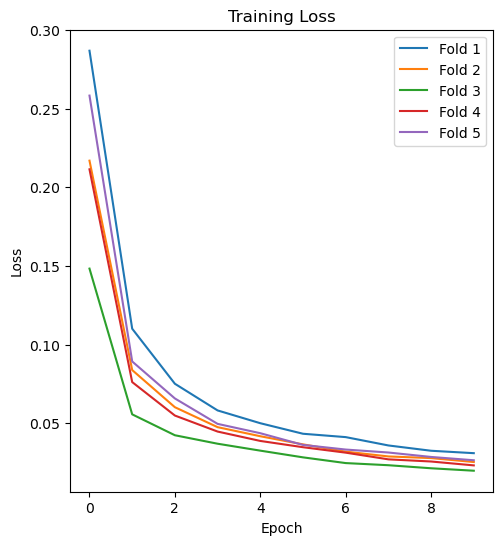

In [12]:
# Eğitim ve validation loss grafiği çizin
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(all_train_loss[i], label=f'Fold {i + 1}')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# TRAIN

In [13]:
specified_learning_rate = 0.001

callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]
u_net_model.compile(
    optimizer=Adam(learning_rate=specified_learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', F1, recall, precision, dice_coef, iou]
)
test_results = u_net_model.fit(
    resized_train_data, 
    resized_train_mask, 
    batch_size=32, 
    epochs=80, 
    validation_data=(resized_validation_data, resized_validation_mask),
    callbacks=callbacks
)


Epoch 1/80
59/61 [============================>.] - ETA: 44s - loss: 0.1546 - accuracy: 0.9644 - F1: 0.4045 - recall: 0.7418 - precision: 0.7579 - dice_coef: 0.4562 - iou: 0.2765 

AbortedError: Graph execution error:

Detected at node 'gradient_tape/UNET/conv2d_14/Conv2D/Conv2DBackpropFilter' defined at (most recent call last):
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\interactiveshell.py", line 2974, in run_cell
      result = self._run_cell(
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\interactiveshell.py", line 3029, in _run_cell
      return runner(coro)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\interactiveshell.py", line 3256, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\interactiveshell.py", line 3472, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\interactiveshell.py", line 3552, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\BUKET\AppData\Local\Temp\ipykernel_12900\1176288877.py", line 11, in <cell line: 11>
      test_results = u_net_model.fit(
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/UNET/conv2d_14/Conv2D/Conv2DBackpropFilter'
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_grad_filter_ops.cc:630
	 [[{{node gradient_tape/UNET/conv2d_14/Conv2D/Conv2DBackpropFilter}}]] [Op:__inference_train_function_5668]

In [14]:
# Modelin ağırlıklarını ve konfigürasyonunu kaydetme
u_net_model.save('unet_model_test_results_0001.h5')

# Eğitim geçmişini kaydetme (pickle ile)
import pickle

with open('training_history_unet_model_test_results_0001.pkl', 'wb') as history_file:
    pickle.dump(test_results.history, history_file)

In [9]:
loaded_half_unet_model = load_model("unet_model_test_results_001.h5", custom_objects={'dice_coef_loss': dice_coef_loss, 
                                                                                    'dice_coef': dice_coef,
                                                                                    'F1':F1, 
                                                                                    'recall':recall, 
                                                                                    'precision':precision,
                                                                                    'iou':iou})


In [10]:
predictions = loaded_half_unet_model.predict(resized_test_data)

def binary_predictions(predictions, threshold=0.4):
    """
    Tahmin olasılıklarını binary değerlere çevirir.

    Argümanlar:
    - predictions: Model tahmin olasılıkları
    - threshold: Eşik değeri

    Returns:
    - binary_predictions: Belirlenen eşik değerine göre ikili tahminler
    """
    binary_predictions = (predictions > threshold).astype(np.uint8)
    return binary_predictions

# Örnek kullanım
predicted_mask_probabilities = loaded_half_unet_model.predict(resized_test_data)  # Modelin tahmin olasılıkları
binary_mask_predictions = binary_predictions(predicted_mask_probabilities, threshold=0.5)


9/9 [==============================] - 43s 5s/step


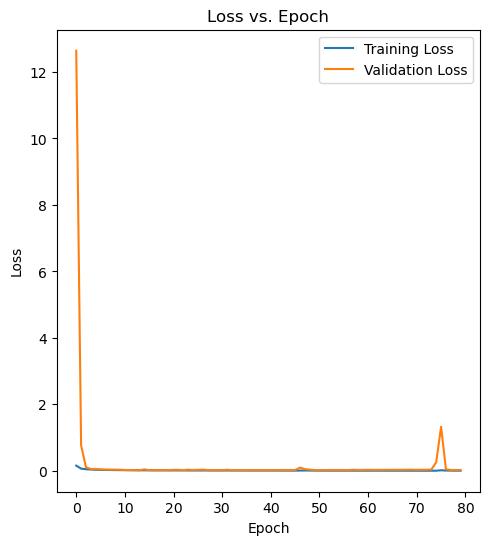

In [11]:
import pickle

# Eğitim geçmişini yükleyin
with open('training_history_unet_model_test_results_001.pkl', 'rb') as history_file:
    history = pickle.load(history_file)
    
# Eğitim geçmişini görselleştirme
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')

plt.show()
